# Neural Network Modeling

## Second Neural Network Model

In [ ]:
# getting device info
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 13366974311144784228, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 10643729511497162273
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 15458586394065018191
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14640891840
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 15797905534949671217
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

In [ ]:
# loading library
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable

from sklearn.metrics import log_loss

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Flatten, Concatenate, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

In [ ]:
# reference: https://machinelearningmastery.com/how-to-save-a-numpy-array-to-file-for-machine-learning/
X_train = np.load('drive/My Drive/KKBox/actual_train.npz')['arr_0']
y_train = np.load('drive/My Drive/KKBox/actual_train_labels.npz')['arr_0']
X_cv = np.load('drive/My Drive/KKBox/actual_cv.npz')['arr_0']
y_cv = np.load('drive/My Drive/KKBox/actual_cv_labels.npz')['arr_0']
test_data = np.load('drive/My Drive/KKBox/actual_test.npz')['arr_0']

# getting shapes
print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(test_data.shape)

(776768, 57) (776768,)
(194192, 57) (194192,)
(907471, 57)


In [ ]:
init = tf.keras.initializers.HeNormal()
regular = tf.keras.regularizers.l2(l2=0.1)

# Input layer
input_layer = Input(shape=(57,))

# Dense hidden layer 1
layer1 = Dense(64, activation='relu', kernel_initializer=init, kernel_regularizer=regular)(input_layer)

# Batch Normalization layer 1
b_norm1 = BatchNormalization()(layer1)

# Dropout layer 1
drop1 = Dropout(rate=0.5)(b_norm1)

# Dense hidden layer 2
layer2 = Dense(32, activation='relu', kernel_initializer=init, kernel_regularizer=regular)(drop1)

# Batch Normalization layer 2
b_norm2 = BatchNormalization()(layer2)

# Dropout layer 2
drop2 = Dropout(rate=0.5)(b_norm2)

# Dense hidden layer 3
layer3 = Dense(16, activation='relu', kernel_initializer=init, kernel_regularizer=regular)(drop2)

# Batch Normalization layer 3
b_norm3 = BatchNormalization()(layer3)

# Dropout layer 3
drop3 = Dropout(rate=0.5)(b_norm3)

# Output layer
output_layer = Dense(1, activation='sigmoid', kernel_initializer=tf.keras.initializers.glorot_uniform(), kernel_regularizer=regular)(drop3)

# Creating a model
model = Model(inputs=input_layer, outputs=output_layer)

# summary
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 57)]              0         
_________________________________________________________________
dense (Dense)                (None, 64)                3712      
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)               

In [ ]:
# Compile model
adam = tf.keras.optimizers.Adam()

model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

In [ ]:
filepath = "drive/My Drive/KKBox/best_model_1.h5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

es = EarlyStopping(monitor='val_loss', patience=3, mode='min', verbose=1, restore_best_weights=True)

cb = [es, checkpoint]

In [ ]:
# Fit the model
history = model.fit(X_train, y_train, epochs=10, batch_size=256, validation_data=(X_cv, y_cv), verbose=1, callbacks=cb)

Epoch 1/10
3032/3035 [============================>.] - ETA: 0s - loss: 1.1517 - accuracy: 0.9246
Epoch 00001: val_loss improved from inf to 0.19554, saving model to drive/My Drive/KKBox/best_model_1.h5
3035/3035 [==============================] - 17s 6ms/step - loss: 1.1510 - accuracy: 0.9246 - val_loss: 0.1955 - val_accuracy: 0.9451
Epoch 2/10
3027/3035 [============================>.] - ETA: 0s - loss: 0.1940 - accuracy: 0.9461
Epoch 00002: val_loss improved from 0.19554 to 0.17692, saving model to drive/My Drive/KKBox/best_model_1.h5
3035/3035 [==============================] - 16s 5ms/step - loss: 0.1940 - accuracy: 0.9461 - val_loss: 0.1769 - val_accuracy: 0.9521
Epoch 3/10
3026/3035 [============================>.] - ETA: 0s - loss: 0.1868 - accuracy: 0.9458
Epoch 00003: val_loss improved from 0.17692 to 0.17252, saving model to drive/My Drive/KKBox/best_model_1.h5
3035/3035 [==============================] - 17s 6ms/step - loss: 0.1868 - accuracy: 0.9459 - val_loss: 0.1725 - va

In [ ]:
# loading best model from disk
model = load_model('drive/My Drive/KKBox/best_model_1.h5')

In [ ]:
# getting probabilities for test data
predictions = model.predict(test_data)
# converting 2d array to 1d using flatten
predictions = predictions.flatten()
# getting test probabilities
predictions

array([0.0253654 , 0.02161816, 0.02240785, ..., 0.02195825, 0.02051795,
       0.02085175], dtype=float32)

In [ ]:
# loading sample submission file
submit = pd.read_csv('drive/My Drive/KKBox/sample_submission_v2.csv')
# dropping default class labels
submit = submit.drop('is_churn', axis=1, inplace=False)
# getting head(top 5 rows)
submit.head()

,msno
0,4n+fXlyJvfQnTeKXTWT507Ll4JVYGrOC8LHCfwBmPE4=
1,aNmbC1GvFUxQyQUidCVmfbQ0YeCuwkPzEdQ0RwWyeZM=
2,rFC9eSG/tMuzpre6cwcMLZHEYM89xY02qcz7HL4//jc=
3,WZ59dLyrQcE7ft06MZ5dj40BnlYQY7PHgg/54+HaCSE=
4,aky/Iv8hMp1/V/yQHLtaVuEmmAxkB5GuasQZePJ7NU4=


In [ ]:
# multiplying 0.6 with class labels, and assigning them to new feature 'is_churn'
submit['is_churn'] = predictions * 0.6
# getting head(top 5 rows)
submit.head()

,msno,is_churn
0,4n+fXlyJvfQnTeKXTWT507Ll4JVYGrOC8LHCfwBmPE4=,0.015219
1,aNmbC1GvFUxQyQUidCVmfbQ0YeCuwkPzEdQ0RwWyeZM=,0.012971
2,rFC9eSG/tMuzpre6cwcMLZHEYM89xY02qcz7HL4//jc=,0.013445
3,WZ59dLyrQcE7ft06MZ5dj40BnlYQY7PHgg/54+HaCSE=,0.014194
4,aky/Iv8hMp1/V/yQHLtaVuEmmAxkB5GuasQZePJ7NU4=,0.015875


In [ ]:
# saving csv file to the disk
submit.to_csv('drive/My Drive/KKBox/submission_ffnn06_1.csv', index=False)

**By using this model I got 0.12136 on public leaderboard as test log-loss and 0.12043 on private leaderboard as test log-loss.**

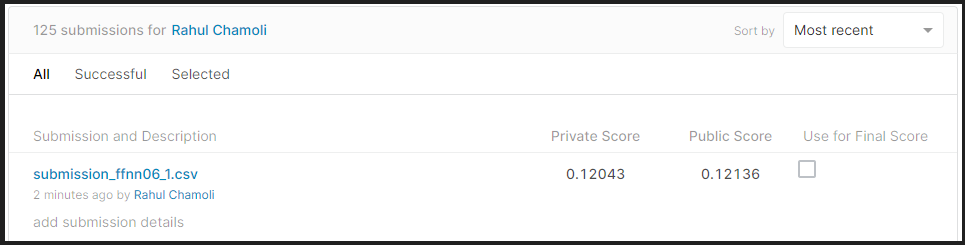

## Third Neural Network Model

In [ ]:
init = tf.keras.initializers.HeNormal()
regular = tf.keras.regularizers.l2(l2=0.1)

# Input layer
input_layer = Input(shape=(57,))

# Dense hidden layer 1
layer1 = Dense(64, activation='relu', kernel_initializer=init, kernel_regularizer=regular)(input_layer)

# Batch Normalization layer 1
b_norm1 = BatchNormalization()(layer1)

# Dropout layer 1
drop1 = Dropout(rate=0.5)(b_norm1)

# Dense hidden layer 2
layer2 = Dense(32, activation='relu', kernel_initializer=init, kernel_regularizer=regular)(drop1)

# Batch Normalization layer 2
b_norm2 = BatchNormalization()(layer2)

# Dropout layer 2
drop2 = Dropout(rate=0.5)(b_norm2)

# Dense hidden layer 3
layer3 = Dense(16, activation='relu', kernel_initializer=init, kernel_regularizer=regular)(drop2)

# Batch Normalization layer 3
b_norm3 = BatchNormalization()(layer3)

# Dropout layer 3
drop3 = Dropout(rate=0.5)(b_norm3)

# Output layer
output_layer = Dense(1, activation='sigmoid', kernel_initializer=tf.keras.initializers.glorot_normal(), kernel_regularizer=regular)(drop3)

# Creating a model
model = Model(inputs=input_layer, outputs=output_layer)

# summary
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 57)]              0         
_________________________________________________________________
dense (Dense)                (None, 64)                3712      
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)               

In [ ]:
# Compile model
adam = tf.keras.optimizers.Adam()

model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

In [ ]:
filepath = "drive/My Drive/KKBox/best_model_2.h5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

es = EarlyStopping(monitor='val_loss', patience=3, mode='min', verbose=1, restore_best_weights=True)

cb = [es, checkpoint]

In [ ]:
# Fit the model
history = model.fit(X_train, y_train, epochs=10, batch_size=256, validation_data=(X_cv, y_cv), verbose=1, callbacks=cb)

Epoch 1/10
3029/3035 [============================>.] - ETA: 0s - loss: 0.7344 - accuracy: 0.9347
Epoch 00001: val_loss improved from inf to 0.27801, saving model to drive/My Drive/KKBox/best_model_2.h5
3035/3035 [==============================] - 16s 5ms/step - loss: 0.7334 - accuracy: 0.9347 - val_loss: 0.2780 - val_accuracy: 0.9020
Epoch 2/10
3027/3035 [============================>.] - ETA: 0s - loss: 0.1925 - accuracy: 0.9460
Epoch 00002: val_loss improved from 0.27801 to 0.21138, saving model to drive/My Drive/KKBox/best_model_2.h5
3035/3035 [==============================] - 16s 5ms/step - loss: 0.1925 - accuracy: 0.9460 - val_loss: 0.2114 - val_accuracy: 0.9348
Epoch 3/10
3030/3035 [============================>.] - ETA: 0s - loss: 0.1872 - accuracy: 0.9458
Epoch 00003: val_loss improved from 0.21138 to 0.16718, saving model to drive/My Drive/KKBox/best_model_2.h5
3035/3035 [==============================] - 16s 5ms/step - loss: 0.1873 - accuracy: 0.9458 - val_loss: 0.1672 - va

In [ ]:
# loading best model from disk
model = load_model('drive/My Drive/KKBox/best_model_2.h5')

# getting predictions for test data
predictions = model.predict(test_data)
# converting 2d array to 1d using flatten
predictions = predictions.flatten()
# getting probabilities
predictions

array([0.02882533, 0.01901679, 0.02031952, ..., 0.02142653, 0.01834583,
       0.01852141], dtype=float32)

In [ ]:
# loading sample submission file
submit = pd.read_csv('drive/My Drive/KKBox/sample_submission_v2.csv')
# dropping default class labels
submit = submit.drop('is_churn', axis=1, inplace=False)
# getting head(top 5 rows)
submit.head()

,msno
0,4n+fXlyJvfQnTeKXTWT507Ll4JVYGrOC8LHCfwBmPE4=
1,aNmbC1GvFUxQyQUidCVmfbQ0YeCuwkPzEdQ0RwWyeZM=
2,rFC9eSG/tMuzpre6cwcMLZHEYM89xY02qcz7HL4//jc=
3,WZ59dLyrQcE7ft06MZ5dj40BnlYQY7PHgg/54+HaCSE=
4,aky/Iv8hMp1/V/yQHLtaVuEmmAxkB5GuasQZePJ7NU4=


In [ ]:
# multiplying 0.6 with class labels, and assigning them to new feature 'is_churn'
submit['is_churn'] = predictions * 0.6
# getting head(top 5 rows)
submit.head()

,msno,is_churn
0,4n+fXlyJvfQnTeKXTWT507Ll4JVYGrOC8LHCfwBmPE4=,0.017295
1,aNmbC1GvFUxQyQUidCVmfbQ0YeCuwkPzEdQ0RwWyeZM=,0.011410
2,rFC9eSG/tMuzpre6cwcMLZHEYM89xY02qcz7HL4//jc=,0.012192
3,WZ59dLyrQcE7ft06MZ5dj40BnlYQY7PHgg/54+HaCSE=,0.015435
4,aky/Iv8hMp1/V/yQHLtaVuEmmAxkB5GuasQZePJ7NU4=,0.019524


In [ ]:
# saving csv file to the disk
submit.to_csv('drive/My Drive/KKBox/submission_ffnn06_2.csv', index=False)

**By using this model I got 0.11980 as public leaderboard test log-loss and 0.11866 as private leaderboard test log-loss.**

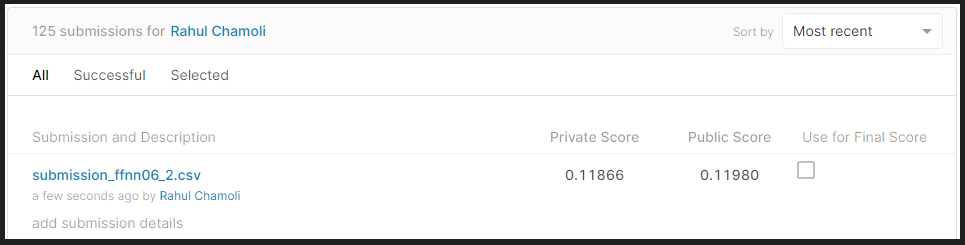

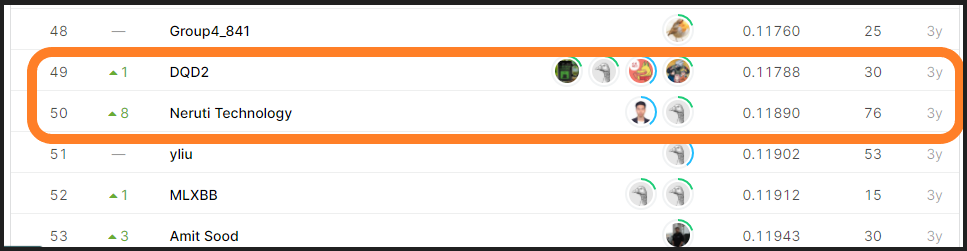

## Simple Average Model

In [ ]:
# Loading first NN model
model1 = load_model('drive/My Drive/KKBox/best_model.h5')

# Loading second NN model
model2 = load_model('drive/My Drive/KKBox/best_model_1.h5')

# Loading third NN model
model3 = load_model('drive/My Drive/KKBox/best_model_2.h5')

In [ ]:
# predict probabilities for the test data using model 1
prediction1 = model1.predict(test_data)
prediction1 = prediction1.flatten()

# predict probabilities for the test data using model 2
prediction2 = model2.predict(test_data)
prediction2 = prediction2.flatten()

# predict probabilities for the test data using model 3
prediction3 = model3.predict(test_data)
prediction3 = prediction3.flatten()

In [ ]:
# combined average prediction
com_pred = (prediction1 + prediction2 + prediction3) / 3
# displaying combined probabilities
com_pred

array([0.02656035, 0.01888013, 0.01996489, ..., 0.02146891, 0.0186058 ,
       0.01815041], dtype=float32)

In [ ]:
# loading sample submission file
submit = pd.read_csv('drive/My Drive/KKBox/sample_submission_v2.csv')
# dropping default class labels
submit = submit.drop('is_churn', axis=1, inplace=False)
# getting head(top 5 rows)
submit.head()

,msno
0,4n+fXlyJvfQnTeKXTWT507Ll4JVYGrOC8LHCfwBmPE4=
1,aNmbC1GvFUxQyQUidCVmfbQ0YeCuwkPzEdQ0RwWyeZM=
2,rFC9eSG/tMuzpre6cwcMLZHEYM89xY02qcz7HL4//jc=
3,WZ59dLyrQcE7ft06MZ5dj40BnlYQY7PHgg/54+HaCSE=
4,aky/Iv8hMp1/V/yQHLtaVuEmmAxkB5GuasQZePJ7NU4=


In [ ]:
# multiplying 0.6 with class labels, and assigning them to new feature 'is_churn'
submit['is_churn'] = com_pred * 0.6
# getting head(top 5 rows)
submit.head()

,msno,is_churn
0,4n+fXlyJvfQnTeKXTWT507Ll4JVYGrOC8LHCfwBmPE4=,0.015936
1,aNmbC1GvFUxQyQUidCVmfbQ0YeCuwkPzEdQ0RwWyeZM=,0.011328
2,rFC9eSG/tMuzpre6cwcMLZHEYM89xY02qcz7HL4//jc=,0.011979
3,WZ59dLyrQcE7ft06MZ5dj40BnlYQY7PHgg/54+HaCSE=,0.014339
4,aky/Iv8hMp1/V/yQHLtaVuEmmAxkB5GuasQZePJ7NU4=,0.018739


In [ ]:
# saving csv file to the disk
submit.to_csv('drive/My Drive/KKBox/submission_nn_combine.csv', index=False)

**By using this model I got 0.11994 as public leaderboard test log-loss, and 0.11898 as private leaderboard test log-loss.**

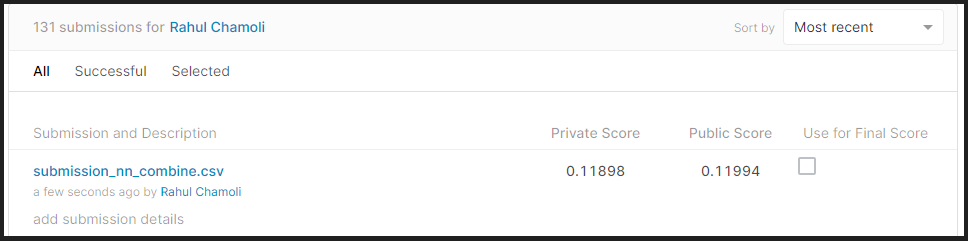

In [1]:
table = PrettyTable()

table.field_names = ['Model name', 'Public leaderboard score', 'Private leaderboard score']

table.add_row(['Random Forest Classifier', 0.15946, 0.15910])
table.add_row(['Decision Tree Classifier', 0.15749, 0.15624])
table.add_row(['Logistic Regression', 0.15197, 0.15148])
table.add_row(['CatBoost', 0.13111, 0.13013])
table.add_row(['XGBoost', 0.12702, 0.12603])
table.add_row(['LightGBM', 0.12697, 0.12600])
table.add_row(['Averaged Model(xgboost + lightGBM)', 0.12660, 0.12562])
table.add_row(['Neural Network Model - 1', 0.12291, 0.12209])
table.add_row(['Neural Network Model - 2', 0.12136, 0.12043])
table.add_row(['Averaged Model(NN1 + NN2 + NN3', 0.11994, 0.11898])
table.add_row(['Neural Network Model - 3', 0.11980, 0.11866])

print(table)

+------------------------------------+--------------------------+---------------------------+
|             Model name             | Public leaderboard score | Private leaderboard score |
+------------------------------------+--------------------------+---------------------------+
|      Random Forest Classifier      |         0.15946          |           0.1591          |
|      Decision Tree Classifier      |         0.15749          |          0.15624          |
|        Logistic Regression         |         0.15197          |          0.15148          |
|              CatBoost              |         0.13111          |          0.13013          |
|              XGBoost               |         0.12702          |          0.12603          |
|              LightGBM              |         0.12697          |           0.126           |
| Averaged Model(xgboost + lightGBM) |          0.1266          |          0.12562          |
|      Neural Network Model - 1      |         0.12291      